In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig

model_name = "../qwen2.5-3b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float32,
    bnb_4bit_use_double_quant=True,
    output_hidden_states=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    dtype=torch.float32
)

#model.eval()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.0,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()


trainable params: 1,843,200 || all params: 3,087,781,888 || trainable%: 0.0597


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot
import copy

import numpy as np

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def check_tensor_dtype(tensor, name):
    if tensor is None:
        print(f"{name}: is None")
        return
    print(f"{name}: dtype = {tensor.dtype}, device = {tensor.device}")

def reward_model(prompt_response) :
    length = prompt_response["input_ids"].shape[1]
    reward = torch.tensor([length], dtype=torch.float32).to('cuda')
    return reward

class ValueHead(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.fc = nn.LazyLinear(1).to(torch.float32)

    def forward(self, x) :
        return self.fc(x)

class Agent() :
    def __init__(self, model, gamma, epsilon, lam, epochs, device) :
        self.model = model
        self.value_head = ValueHead().to(device)
        self.optimizer = torch.optim.AdamW(
            list(self.model.parameters()) + list(self.value_head.parameters()),
            lr=1e-4
        )
        
        self.loss = nn.MSELoss()#.to(torch.float32)

        self.gamma = gamma
        self.epsilon = epsilon
        self.epochs = epochs
        self.lam = lam

        self.device = device

        self.total_loss = []
        
    def take_action(self, state) :
        output = self.model(**state, output_hidden_states=True)
        return output

    def update(self, transition_dict, inputs, response, prompt_response, done, last_hidden_states) :  
        for _ in range(self.epochs) :
            output = self.model(**prompt_response, output_hidden_states=True)

            T = len(transition_dict['action'])
            logits = output.logits[:,-(T+1):-1,:]
            
            dist = torch.distributions.Categorical(logits=logits)
        
            action = torch.cat(transition_dict['action'], dim=0).to(self.device)
            log_p_new = dist.log_prob(action)
            with torch.no_grad():
                log_p_old = torch.cat(transition_dict['log_p']).unsqueeze(0)

            ratio = torch.exp(log_p_new - log_p_old)
        
            reward = reward_model(response)
            v_t = torch.cat(transition_dict['value_head'], dim=1).to(self.device)
            last_v = torch.tensor([[0.0]]).to(self.device) if done else self.value_head(last_hidden_states)
            v_t1 = torch.cat([v_t[:, 1:], last_v], dim=1).to(self.device)
            r_t = torch.zeros_like(v_t).to(self.device)
            r_t[:, -1] = reward
            delta_t = r_t + self.gamma * v_t1 - v_t
            adv = torch.zeros_like(delta_t).to(self.device)
            for i in reversed(range(adv.shape[1])) :
                adv[:, i] = self.gamma * self.lam * adv[:, i+1] + delta_t[:, i] if i+1 < adv.shape[1] else delta_t[:, i]
            adv = adv.detach()

            entropy = dist.entropy().sum()
        
            policy_loss = -torch.mean(torch.min(
                ratio * adv,
                torch.clamp(ratio, 1-self.epsilon, 1+self.epsilon) * adv
            ))# - 0.01 * entropy)

            new_v_t = self.value_head(
                output.hidden_states[-1][:, -(T+1):-1, :]
            )
            value_loss = F.mse_loss(new_v_t.squeeze(-1), (adv + v_t).detach())
        
            loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

# agent init
gamma = 0.98
epsilon = 0.2
epochs = 10
lam = 1
agent = Agent(model, gamma, epsilon, lam, epochs, 'cuda')

epoch_num = 200
max_iter = 100

return_list = []
reward_list = []

prompt = "请用一句话解释什么是强化学习。"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
newline_token_id = tokenizer.encode("\n", add_special_tokens=False)[0]

for i in range(epoch_num // 2) :
    for j in range(2) :
        observation = inputs
        done = False
        total_reward = 0
        iter = 0
        #prompt = tokenizer.decode(observation["input_ids"][0])
        #print("prompt:", prompt)
        
        transition_dict = {'action': [], 'log_p':[], 'value_head':[]}
        while (not done and iter < max_iter):
            output = agent.take_action(observation)

            dist = torch.distributions.Categorical(logits=output.logits[:,-1,:])
            action = dist.sample()
            log_p = dist.log_prob(action)
            value_head = agent.value_head(output.hidden_states[-1][:,-1,:].to(agent.value_head.fc.weight.dtype))

            next_input_ids = torch.cat([observation["input_ids"], action.unsqueeze(-1)], dim=1)
            next_attention_mask = torch.cat([observation["attention_mask"], torch.ones_like(action.unsqueeze(-1))], dim = 1)
            next_observation = {
                "input_ids": next_input_ids,
                "attention_mask": next_attention_mask
            }
            
            done = (action == tokenizer.eos_token_id)

            # 采样的数据只是样本，用来计算优势，衡量和新策略的距离，都是标量，不用反向传播。
            transition_dict['log_p'].append(log_p.detach())
            transition_dict['action'].append(action.detach())
            transition_dict['value_head'].append(value_head.detach())

            observation = next_observation

            if done or iter == max_iter - 1 :
                response_ids = next_input_ids[:,inputs['input_ids'].shape[1]:]
                response_attention_mask = next_attention_mask[:, inputs['attention_mask'].shape[1]:]
                response = {
                    "input_ids": response_ids,
                    "attention_mask": response_attention_mask
                }

                agent.update(transition_dict, inputs, response, observation, done, agent.take_action(observation).hidden_states[-1][:,-1,:])

            iter += 1

        reward_list.append(reward_model(response).to('cpu').item())
        #text = tokenizer.decode(observation["input_ids"][0])
        #print("response:", text)


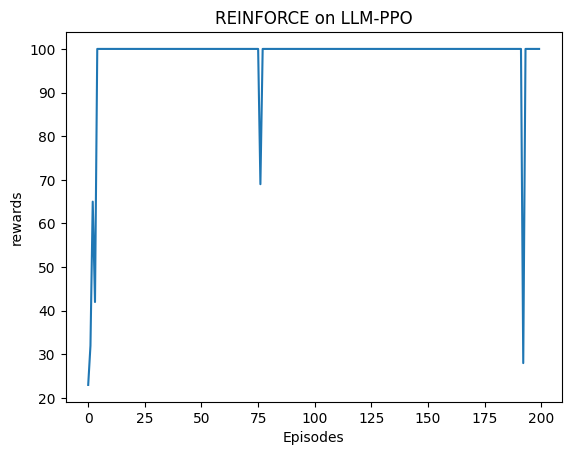

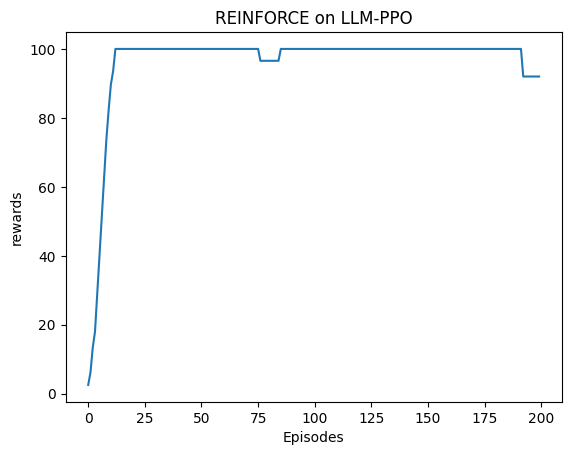

In [4]:
import matplotlib.pyplot as plt
env_name = "LLM-PPO"

episodes_list = list(range(len(reward_list)))
plt.plot(episodes_list, reward_list)
plt.xlabel('Episodes')
plt.ylabel('rewards')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

def moving_average(targets, truncated_num) :
    truncated_sum = 0
    queue = []
    results = []
    for target in targets :
        queue.append(target)
        truncated_sum += target
        results.append(truncated_sum / truncated_num)
        if len(queue) == truncated_num :
            truncated_sum -= queue.pop(0)
            
    return results

mv_return = moving_average(reward_list, 9)
#print(return_list, mv_return)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('rewards')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()